In [ ]:
! pip install numpy pandas xlrd matplotlib seaborn scipy statsmodels scikit-learn imbalanced-learn ppscore tensorflow minisom lime shap geopy folium

In [34]:
cityname = "Raipur"
dataset_path = 'my-sample.csv'

In [35]:
import warnings
warnings.filterwarnings("ignore")
from ml_utils import *

In [36]:
df = pd.read_csv(dataset_path)
df = df.reset_index().rename(columns = {
    "index": "id"
})
df.drop(columns=["ID"], inplace=True)

ptype = []

for i in df['Population']:
    if(0 <= i <= 10000):
        ptype.append("Low")
    elif(10001 <= i <= 30000):
        ptype.append("Mid")
    else:
        ptype.append("High")

df["Population Density"] = ptype
df.head()

,id,Pin Code,Name,Latitude,Longitude,Population,Area (km),Population Density
0,0,492004,Shankar Nagar,21.249373,81.665430,19893,3.56,Mid
1,1,492007,Mowa,21.274871,81.634055,26767,7.93,Mid
2,2,492001,Mahaveer Nagar,21.226893,81.663033,15246,3.97,Mid
3,3,492007,New Shanti Nagar,21.246982,81.647489,5129,0.31,Low
4,4,492101,Nardaha,21.293952,81.739268,6575,14.15,Low


In [37]:
# Get coordinates to start the map
location = get_geocoder(address = cityname)
print("[lat, long]:", location)

In [38]:

map_ = plot_map(df, x="Latitude", y="Longitude", start=location, zoom=11, 
                tiles="cartodbpositron", popup="Name", 
                size="Area (km)", color="Population Density", lst_colors=["red","green","orange"], legend=True,
                marker=None)
map_

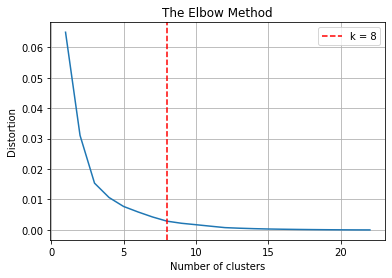

In [39]:
# K-means (euclidean geom, even clusters, must specify k)
k = find_best_k(df[["Latitude","Longitude"]], max_k = 50)
print("k = ", k)

In [40]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = k, init = 'k-means++')

In [41]:
model.fit(df[["Latitude","Longitude"]])
model

KMeans()

In [42]:
coord_clusters = model.cluster_centers_
coord_clusters

array([[21.25997965, 81.67492347],
       [21.24001463, 81.6336209 ],
       [21.293952  , 81.7392679 ],
       [21.3095552 , 81.5854673 ],
       [21.2590702 , 81.5556516 ],
       [21.22504897, 81.65571625],
       [21.314799  , 81.787518  ],
       [21.27647063, 81.61868453]])

In [43]:
cluster_vals = model.predict(df[["Latitude","Longitude"]])
cluster_vals

array([0, 7, 5, 1, 2, 0, 5, 0, 5, 1, 7, 3, 5, 1, 7, 0, 6, 1, 1, 1, 1, 4],
      dtype=int32)

In [44]:
from haversine import haversine, Unit
cluster_lat, cluster_long = [], []
dist = []
idx = 0

point_lat = df['Latitude'].to_numpy()
point_long = df['Longitude'].to_numpy()

print(point_lat)

for cluster_val in cluster_vals:
    (x, y) = coord_clusters[cluster_val]
    cluster_lat.append(x)
    cluster_long.append(y)
    dist.append(haversine((x, y), (point_lat[idx], point_long[idx])))
    idx += 1

In [45]:
df['Cluster Latitude'] = cluster_lat
df['Cluster Longitude'] = cluster_long
df['Cluster'] = cluster_vals
df['Cluster Distance'] = dist

In [46]:
df.head()

,id,Pin Code,Name,Latitude,Longitude,Population,Area (km),Population Density,Cluster Latitude,Cluster Longitude,Cluster,Cluster Distance
0,0,492004,Shankar Nagar,21.249373,81.665430,19893,3.56,Mid,21.259980,81.674923,0,1.535907
1,1,492007,Mowa,21.274871,81.634055,26767,7.93,Mid,21.276471,81.618685,7,1.602517
2,2,492001,Mahaveer Nagar,21.226893,81.663033,15246,3.97,Mid,21.225049,81.655716,5,0.785592
3,3,492007,New Shanti Nagar,21.246982,81.647489,5129,0.31,Low,21.240015,81.633621,1,1.632768
4,4,492101,Nardaha,21.293952,81.739268,6575,14.15,Low,21.293952,81.739268,2,0.000000


In [47]:
colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

In [48]:
cdf = df = df.groupby('Cluster', as_index=False).agg({'Population':'sum', 'Cluster Distance':'sum'})
cdf[['Latitude', 'Longitude']] = coord_clusters
cdf['Station Name'] = [f"{i + 1}" for i in range(k)]

In [49]:
cdf

,Cluster,Population,Cluster Distance,Latitude,Longitude,Station Name
0,0,34440,3.883552,21.259980,81.674923,1
1,1,29920,9.281051,21.240015,81.633621,2
2,2,6575,0.000000,21.293952,81.739268,3
3,3,83394,0.000000,21.309555,81.585467,4
4,4,22379,0.000000,21.259070,81.555652,5
5,5,44370,4.576609,21.225049,81.655716,6
6,6,2817,0.000000,21.314799,81.787518,7
7,7,62335,4.070862,21.276471,81.618685,8


In [50]:
idx = 0
for (x, y) in model.cluster_centers_:
    html=f"""
        <link href='http://fonts.googleapis.com/css?family=Roboto' rel='stylesheet' type='text/css'>
        <div style = "font-family: 'Roboto', sans-serif;">
            <h4> Cluster {idx + 1}</h4>
            <p>Details: </p>
            <ul>
                <li>Population: {cdf.iloc[idx, 1]}</li>
                <li>WSS: {cdf.iloc[idx, 2]:.5f} km</li>
            </ul>
            </p>
        <div>
        """
    iframe = folium.IFrame(html=html, width=200, height=160)
    popup = folium.Popup(iframe, max_width=2650)
    folium.Marker(
        location = [x, y],
        popup = popup,
        icon = folium.Icon(
            color = colors[idx]
        )
    ).add_to(map_)
    idx += 1

map_

In [51]:
from mst_utils import *
mst_map = gen_mst(cityname, cdf)

In [52]:
idx = 0
for (x, y) in model.cluster_centers_:
    # With-in-Sum-of-Squares (WSS): WSS is the total distance of data points from their respective cluster centroids.
    html=f"""
        <link href='http://fonts.googleapis.com/css?family=Roboto' rel='stylesheet' type='text/css'>
        <div style = "font-family: 'Roboto', sans-serif;">
            <h4> Station {idx + 1}</h4>
            <p>Details: </p>
            <ul>
                <li>Population: {cdf.iloc[idx, 1]}</li>
                <li>WSS: {cdf.iloc[idx, 2]:.5f} km</li>
            </ul>
        <div>
        """
    iframe = folium.IFrame(html=html, width=200, height=160)
    popup = folium.Popup(iframe, max_width=2650)
    folium.Marker(
        location = [x, y],
        popup = popup,
        icon = folium.Icon(
            color = colors[idx]
        )
    ).add_to(mst_map)
    idx += 1

In [53]:
mst_map